# 🧠 CNN on MNIST using PyTorch
Train a simple convolutional neural network on MNIST dataset using GPU (if available)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING logs

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# TensorFlow test
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)
print(c)


Num GPUs Available:  1
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor([[11.]], shape=(1, 1), dtype=float32)


In [4]:
# PyTorch test
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))
x = torch.rand(3, 3).cuda()
print(x)


CUDA available: True
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU
tensor([[0.4335, 0.4188, 0.0939],
        [0.8734, 0.6290, 0.4833],
        [0.7573, 0.3250, 0.5384]], device='cuda:0')


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # -> (28 - 3 + 1 = 26)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # -> (26 - 3 + 1 = 24)
        self.pool = nn.MaxPool2d(2)                    # -> (24 / 2 = 12)
        self.dropout = nn.Dropout(0.25)

        # Use dummy input to compute the shape dynamically
        dummy_input = torch.zeros(1, 1, 28, 28)
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
        self.flat_dim = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # (batch, 32, 26, 26)
        x = self.pool(F.relu(self.conv2(x)))  # (batch, 64, 12, 12)
        x = x.view(x.size(0), -1)       # (batch, 64*12*12)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter instance
writer = SummaryWriter(log_dir='runs/mnist_experiment')


In [10]:
# Place this in a new cell BEFORE you log the model
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


In [11]:
# Log the model architecture (only once, before training loop)
sample_input = torch.randn(1, 1, 28, 28).to(device)
writer.add_graph(model, sample_input)

In [12]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Log loss every 100 batches
        if batch_idx % 100 == 0:
            writer.add_scalar('Loss/Train_Batch', loss.item(), epoch * len(trainloader) + batch_idx)

    # Log total loss per epoch
    writer.add_scalar('Loss/Train_Epoch', total_loss, epoch)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 124.1173
Epoch 2, Loss: 41.7110
Epoch 3, Loss: 27.3653


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # ✅ Log image grid just once — break after first batch
        # img_grid = torchvision.utils.make_grid(images[:6].cpu())
        img_grid = make_grid(images[:6].cpu())

        writer.add_image('mnist_images', img_grid)
        break  # Prevent logging images for every batch

print(f"Accuracy on test set: {100 * correct / total:.2f}%")
writer.add_scalar('Accuracy/Test', 100 * correct / total, epoch)



Accuracy on test set: 98.00%


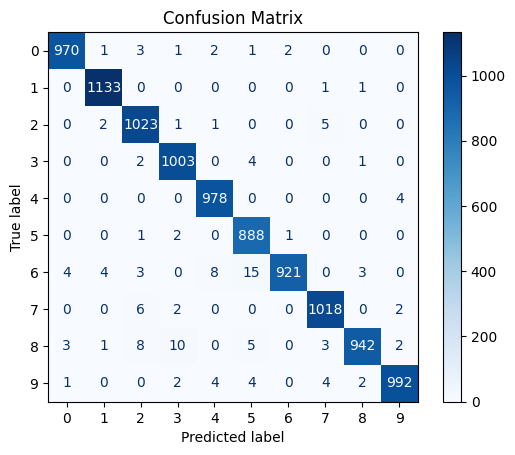

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute and plot
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [19]:
classes = list(range(10))
correct_per_class = [0] * 10
total_per_class = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for label, pred in zip(labels, preds):
            total_per_class[label.item()] += 1
            if pred.item() == label.item():
                correct_per_class[label.item()] += 1

for i, cls in enumerate(classes):
    acc = 100 * correct_per_class[i] / total_per_class[i]
    print(f"Accuracy for class {cls}: {acc:.2f}%")


Accuracy for class 0: 98.98%
Accuracy for class 1: 99.82%
Accuracy for class 2: 99.13%
Accuracy for class 3: 99.31%
Accuracy for class 4: 99.59%
Accuracy for class 5: 99.55%
Accuracy for class 6: 96.14%
Accuracy for class 7: 99.03%
Accuracy for class 8: 96.71%
Accuracy for class 9: 98.32%


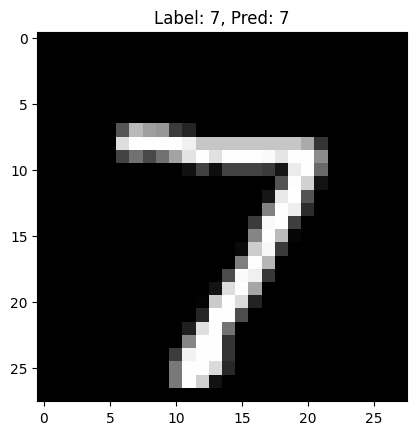

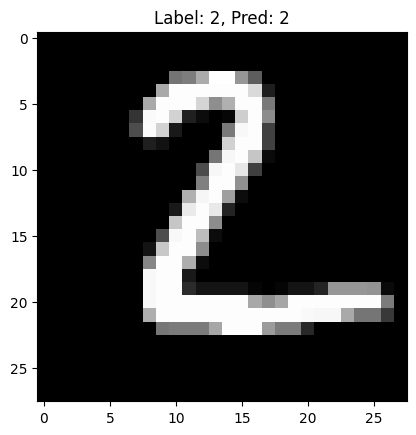

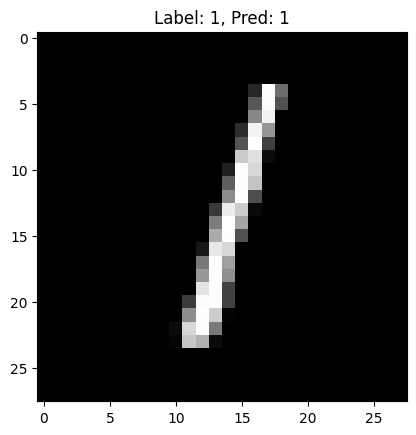

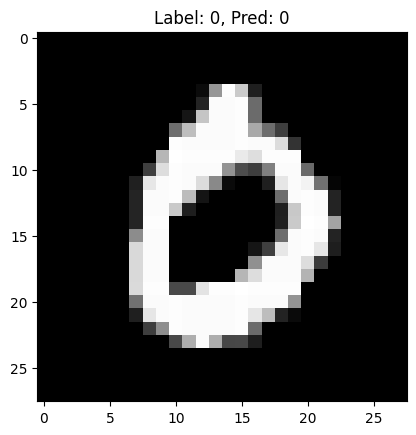

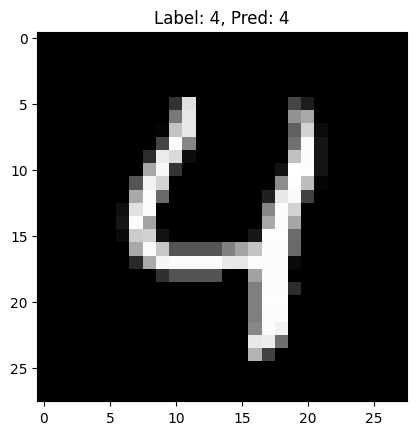

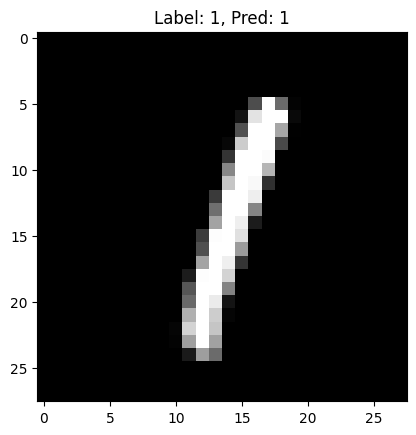

In [16]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

# Show first 6 test images with predictions
for i in range(6):
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}, Pred: {predicted[i]}")
    plt.show()


In [17]:
writer.close()

In [ ]:
from torchsummary import summary
summary(model, (1, 28, 28))
